In [1]:
import os
import joblib
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# ------------------ CONFIG ------------------
DATA_CSV = "datasets/preed Crop Recommendation using Soil Properties and Weather Prediction.csv"  # <- change to your dataset path
TARGET_COL = "label"
DROP_COLS = [TARGET_COL, "Soilcolor", "label_encoded"]
N_TRIALS = 100               # increase if you want more search
OUTPUT_DIR = "artifacts"
TEST_SIZE = 0.2
RANDOM_STATE = None

In [3]:
# --------------------------------------------
# Load data
df = pd.read_csv(DATA_CSV)
X = df.drop(columns=DROP_COLS)
y = df[TARGET_COL]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, stratify=y_encoded, random_state=RANDOM_STATE
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
joblib.dump(scaler, f"{OUTPUT_DIR}/scaler.pkl")
joblib.dump(le, f"{OUTPUT_DIR}/label_encoder.pkl")

['artifacts/label_encoder.pkl']

In [5]:
# -----------------------------
# Custom sparse focal loss
# -----------------------------
def sparse_focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        # y_true: (batch,) with int labels
        # y_pred: (batch, n_classes) with softmax outputs
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)  # avoid log(0)
        
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        loss = weights * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss


# -----------------------------
# Keras model builder
# -----------------------------
def build_model(trial, input_dim, n_classes):
    n_layers = trial.suggest_int("n_layers", 1, 12)
    
    model = tf.keras.Sequential()
    for i in range(n_layers):
        units = trial.suggest_categorical(f"units_l{i}", [16, 32, 64, 128, 256, 512, 1024])
        activation = trial.suggest_categorical(f"activation_l{i}", ["relu", "leaky_relu", "elu", "selu", "tanh", "gelu", "swish"])
        dropout_rate = trial.suggest_float(f"dropout_l{i}", 0.0, 0.6)
        use_bn = trial.suggest_categorical(f"batchnorm_l{i}", [True, False])
        
        if i == 0:
            model.add(tf.keras.layers.Dense(units,
                                            activation=None,
                                            kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                l1=trial.suggest_float("l1_reg", 1e-8, 1e-3, log=True),
                                                l2=trial.suggest_float("l2_reg", 1e-8, 1e-2, log=True)
                                            ),
                                            input_dim=input_dim))
        else:
            model.add(tf.keras.layers.Dense(units, activation=None))
        
        if use_bn:
            model.add(tf.keras.layers.BatchNormalization())
        
        # Activation separately so leaky_relu/gelu/swish work
        if activation == "leaky_relu":
            model.add(tf.keras.layers.LeakyReLU())
        elif activation == "gelu":
            model.add(tf.keras.layers.Activation(tf.nn.gelu))
        elif activation == "swish":
            model.add(tf.keras.layers.Activation(tf.nn.swish))
        else:
            model.add(tf.keras.layers.Activation(activation))
        
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))
    
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "adamw", "nadam", "rmsprop", "sgd"])
    lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)
    
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "adamw":
        optimizer = tf.keras.optimizers.AdamW(learning_rate=lr)
    elif optimizer_name == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=trial.suggest_float("momentum", 0.5, 0.99))
    
    loss_fn = trial.suggest_categorical("loss", ["sparse_categorical_crossentropy", "focal_loss"])
    if loss_fn == "focal_loss":
        loss_fn = sparse_focal_loss()
    
    model.compile(optimizer=optimizer,
                  loss=loss_fn,
                  metrics=["accuracy"])
    return model


In [6]:
# -----------------------------
# Objective function
# -----------------------------
def objective(trial):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    val_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = build_model(trial, input_dim=X_train.shape[1], n_classes=len(np.unique(y_encoded)))

        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )]
        )

        score = model.evaluate(X_val, y_val, verbose=0)[1]
        val_scores.append(score)

    return np.mean(val_scores)

In [7]:
# -----------------------------
# Callback: log best trial live
# -----------------------------
def log_best_callback(study, trial):
    if study.best_trial == trial:
        df_trials = study.trials_dataframe()
        df_trials.to_csv(f"{OUTPUT_DIR}/optuna_trials.csv", index=False)


# -----------------------------
# Run study
# -----------------------------
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[log_best_callback])

# Save study results
df_trials = study.trials_dataframe()
df_trials.to_csv(f"{OUTPUT_DIR}/optuna_trials.csv", index=False)

print("Best trial:")
print(study.best_trial.params)

[I 2025-09-05 23:32:38,018] A new study created in memory with name: no-name-635a749a-9d82-40b3-b43d-f3a548054c06
D:\Python\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-09-05 23:40:56,070] Trial 0 finished with value: 0.09472657988468806 and parameters: {'n_layers': 9, 'units_l0': 32, 'activation_l0': 'leaky_relu', 'dropout_l0': 0.09587921427821107, 'batchnorm_l0': False, 'l1_reg': 1.588125867619363e-05, 'l2_reg': 0.004125375162848118, 'units_l1': 32, 'activation_l1': 'swish', 'dropout_l1': 0.3211974531673781, 'batchnorm_l1': False, 'units_l2': 1024, 'activation_l2': 'elu', 'dropout_l2': 0.03660070498683854, 'batchnorm_l2': False, 'units_l3': 1024, 'activation_l3': 'selu', 'dropout_l3': 0.40893957347805904, 'batchnorm_

Best trial:
{'n_layers': 6, 'units_l0': 1024, 'activation_l0': 'tanh', 'dropout_l0': 0.2948587059470727, 'batchnorm_l0': True, 'l1_reg': 2.364860471699336e-06, 'l2_reg': 2.9558846493465184e-07, 'units_l1': 128, 'activation_l1': 'relu', 'dropout_l1': 0.046131391772927736, 'batchnorm_l1': False, 'units_l2': 1024, 'activation_l2': 'tanh', 'dropout_l2': 0.00579573219450665, 'batchnorm_l2': True, 'units_l3': 32, 'activation_l3': 'elu', 'dropout_l3': 0.3152401210780189, 'batchnorm_l3': True, 'units_l4': 512, 'activation_l4': 'leaky_relu', 'dropout_l4': 0.18813724194490697, 'batchnorm_l4': False, 'units_l5': 512, 'activation_l5': 'leaky_relu', 'dropout_l5': 0.13714484100930696, 'batchnorm_l5': True, 'optimizer': 'adamw', 'lr': 0.0023172564729785705, 'loss': 'sparse_categorical_crossentropy', 'batch_size': 32}


In [15]:
# --------------------------------------------
# Train final model on train+val with best params
best_params = study.best_trial.params
final_model = build_model(study.best_trial, input_dim=X_train.shape[1], n_classes=len(np.unique(y_encoded)))

final_model.fit(X_train, y_train,
                epochs=200,
                batch_size=best_params["batch_size"],
                validation_split=0.15,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True)]
               )

# Save final model
final_model.save(f"{OUTPUT_DIR}/best_model.keras")

D:\Python\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



ERROR! Session/line number was not unique in database. History logging moved to new session 400
Epoch 1/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.3208 - loss: 2.0715 - val_accuracy: 0.3784 - val_loss: 1.8318
Epoch 2/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.3835 - loss: 1.8093 - val_accuracy: 0.4315 - val_loss: 1.6288
Epoch 3/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4217 - loss: 1.6968 - val_accuracy: 0.4737 - val_loss: 1.5261
Epoch 4/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4417 - loss: 1.6352 - val_accuracy: 0.5055 - val_loss: 1.4508
Epoch 5/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.4669 - loss: 1.5714 - val_accuracy: 0.5000 - val_loss: 1.4168
Epoch 6/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4862 - loss: 1.5154 - val_accuracy: 0.5038 - val_loss: 1.4140
Epoch 7/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5022 - loss: 1.4662 - val_accuracy: 0.5586 - val_

In [19]:
# --------------------------------------------
# Evaluate on test set
y_pred = np.argmax(final_model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

print("Test Accuracy:", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Test Accuracy: 0.8278015116661189
Classification Report:
              precision    recall  f1-score   support

      Barley       0.70      0.70      0.70       264
        Bean       0.75      0.85      0.80       261
     Dagussa       0.87      0.97      0.91       254
      Fallow       0.93      1.00      0.96       253
       Maize       0.70      0.61      0.65       250
  Niger seed       0.88      0.97      0.92       248
         Pea       0.90      0.95      0.92       257
      Potato       0.92      0.99      0.95       255
  Red Pepper       0.89      1.00      0.94       253
     Sorghum       0.92      0.98      0.95       252
        Teff       0.65      0.38      0.48       252
       Wheat       0.66      0.53      0.59       244

    accuracy                           0.83      3043
   macro avg       0.81      0.83      0.82      3043
weighted avg       0.82      0.83      0.82      3043



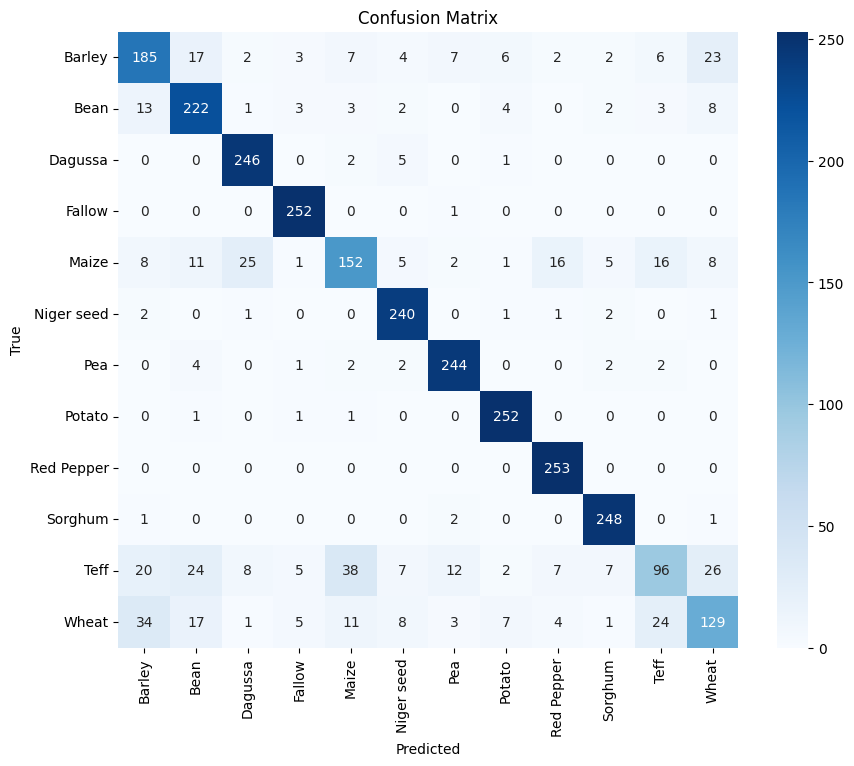

In [20]:
# Save metrics
import json
with open(f"{OUTPUT_DIR}/test_metrics.json", "w") as f:
    json.dump({"accuracy": acc, "report": report}, f, indent=4)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

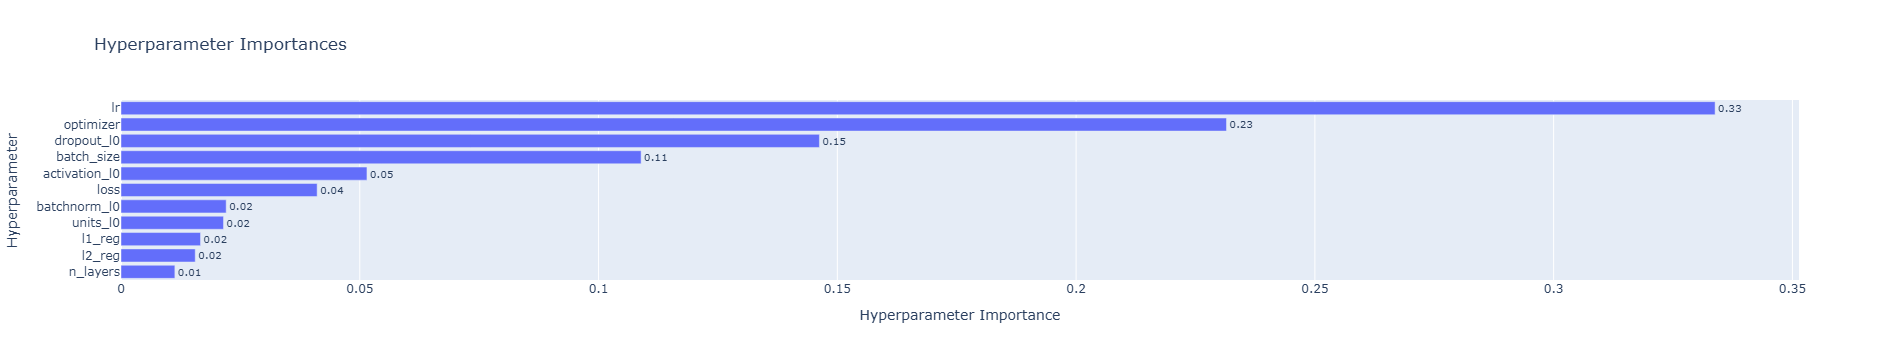

In [11]:
# Optuna visualization
optuna.visualization.plot_param_importances(study)

In [14]:
joblib.dump(study, f"{OUTPUT_DIR}/study.pkl")

['artifacts/study.pkl']

In [16]:
study

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, optimizers, Sequential

def build_fixed_model(input_dim, n_classes):
    model = Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for _ in range(5):  # 5 hidden layers
        model.add(layers.Dense(
            512, 
            activation="tanh",
            kernel_regularizer=regularizers.l2(2.3e-6)
        ))
        model.add(layers.Dropout(0.055))
    
    model.add(layers.Dense(n_classes, activation="softmax"))

    optimizer = optimizers.Adam(learning_rate=2e-4)

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [39]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train, num_classes=len(np.unique(y_encoded)))

model = build_fixed_model(input_dim=X_train.shape[1], n_classes=len(np.unique(y_encoded)))
model.fit(X_train, y_train_oh, batch_size=8, epochs=500, validation_split=0.1)

Epoch 1/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.3765 - loss: 1.8719 - val_accuracy: 0.4097 - val_loss: 1.8372
Epoch 2/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.4433 - loss: 1.6640 - val_accuracy: 0.4704 - val_loss: 1.5414
Epoch 3/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.5313 - loss: 1.3916 - val_accuracy: 0.5673 - val_loss: 1.2840
Epoch 4/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.6101 - loss: 1.1691 - val_accuracy: 0.6117 - val_loss: 1.1371
Epoch 5/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.6600 - loss: 1.0096 - val_accuracy: 0.6519 - val_loss: 1.0064
Epoch 6/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.7022 - loss: 0.8900 - val_accuracy: 0.6798 - val_loss: 0.9609
Epoch 7/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.7353 - loss: 0.7895 - val_accuracy: 0.7184 - val_loss: 0.8456
Epoch 8/500
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 

KeyboardInterrupt: 

In [40]:
# --------------------------------------------
# Evaluate on test set
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

print("Test Accuracy:", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test Accuracy: 0.8356884653302662
Classification Report:
              precision    recall  f1-score   support

      Barley       0.77      0.65      0.71       264
        Bean       0.78      0.88      0.83       261
     Dagussa       0.87      0.98      0.92       254
      Fallow       0.96      1.00      0.98       253
       Maize       0.66      0.65      0.65       250
  Niger seed       0.92      0.95      0.93       248
         Pea       0.92      0.94      0.93       257
      Potato       0.97      0.99      0.98       255
  Red Pepper       0.95      1.00      0.97       253
     Sorghum       0.90      0.98      0.94       252
        Teff       0.55      0.45      0.49       252
       Wheat       0.68      0.55      0.61       244

    accuracy                           0.84      3043
   macro avg       0.83      0.84      0.83      3043
weighted avg       0.83      0.84      0.83      3043



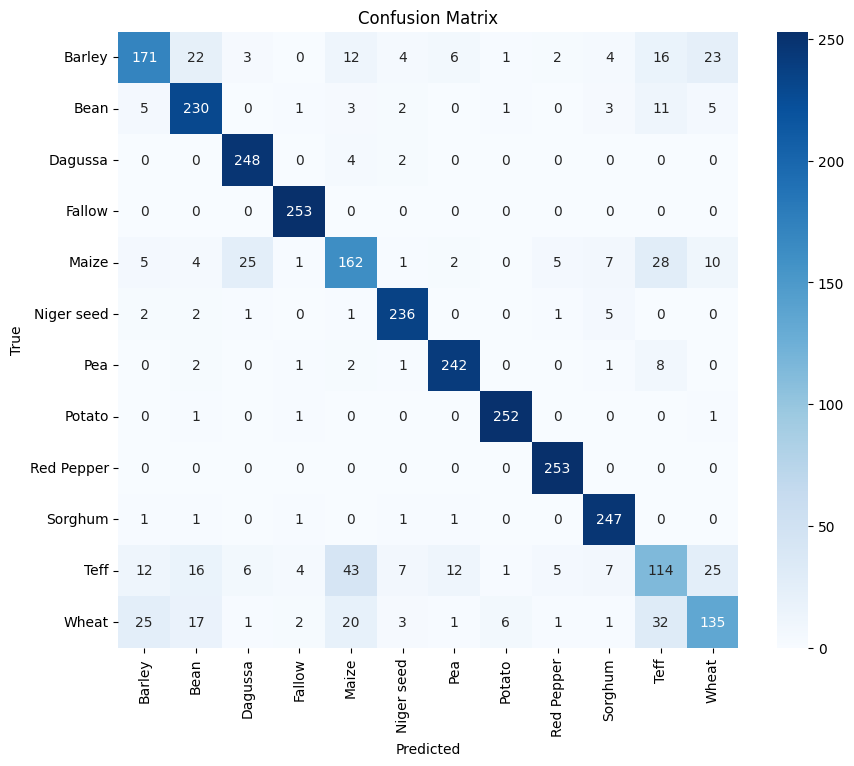

In [41]:
with open(f"{OUTPUT_DIR}/test_metrics_old.json", "w") as f:
    json.dump({"accuracy": acc, "report": report}, f, indent=4)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

In [42]:
model.save(f"{OUTPUT_DIR}/best_model_old_acc84.keras")